# Delay Estimation
OpendTect has the [Match Delta](http://doc.opendtect.org/6.0.0/doc/od_userdoc/Default.htm#appendix_a-attributes_and_filters/match_delta.htm%3FTocPath%3D11%2520Appendix%2520A%2520-%2520Attributes%2520and%2520Filters%7C_____13) atttribute to measure time shifts between similar events in different seismic volumes. It works by finding the peaks in each volume and then tries to match them up. The algorithm is simple and fast but the results can be quite noisy. The following is a the result of running Match Delta between a depth section and itself shifted up by 13 metres. 

![](images/match_delta.jpeg)

The purpose of this notebook is to test some other options that could then be used in an [External Attribute](http://waynegm.github.io/OpendTect-Plugin-Docs/Attributes/ExternalAttrib/) script.


## Simple Test Signal

Populating the interactive namespace from numpy and matplotlib


(1000,)

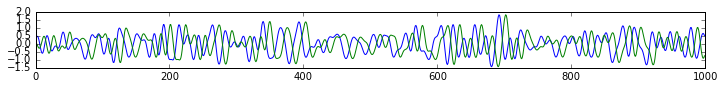

In [1]:
import numpy as np
import scipy.signal as sig
import matplotlib.pyplot as plt
%pylab inline

def make_signals(nsamp,delay ):
    ref = np.random.rand(nsamp+abs(delay))*2-1
    wav = sig.ricker(80,5)
    filtered = np.convolve(ref, wav,'same')
    if delay < 0 :
        return filtered[0:nsamp], filtered[-delay:nsamp-delay]
    else:
        return filtered[delay:nsamp+delay], filtered[0:nsamp]
    
res, shifted = make_signals(1000,10)
fig = plt.figure(figsize=(12,1))
plt.plot(res)
plt.plot(shifted)
shifted.shape

## Local Normalised Cross-correlation
Here is a mainly numpy version of local normalised cross-correlation.

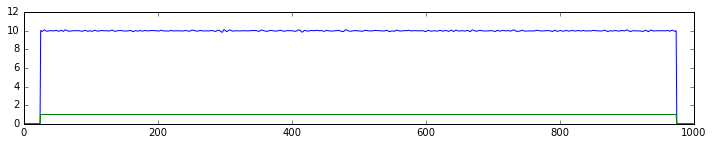

In [68]:
#
# Rolling summ of squares
def rollingSSQ(inp, winlen):
    inpsq = np.square(inp)
    kernel = np.ones(winlen)
    return np.convolve(inpsq, kernel, 'same')
    
def localCorr_numpy(reference, match, winlen, nlag,lag,qual):
    hwin = winlen//2
    lags = 2*nlag+1
    ns = reference.shape[0]
    hxw = hwin-nlag
    cor = np.zeros(lags)
    refSSQ = np.sqrt(rollingSSQ(reference,2*hxw+1))
    matSSQ = np.sqrt(rollingSSQ(match,2*hxw+1))
    for ir in range(hwin,ns-hwin):
        rbeg = ir - hxw
        rend = ir + hxw + 1
        mbeg = rbeg - nlag
        mend = rend + nlag 
        cor = np.divide(np.correlate(match[mbeg:mend],reference[rbeg:rend],'valid'),matSSQ[ir-nlag:ir+nlag+1]*refSSQ[ir])
        pos = np.argmax(cor)
        if pos>0 and pos<lags-1:
            cp = (cor[pos-1]-cor[pos+1])/(2.*cor[pos-1]-4.*cor[pos]+2.*cor[pos+1])
            lag[ir] = pos-nlag+cp
            qual[ir] = cor[pos]
        else:
            lag[ir]=0.0
            qual[ir]=0.0

lag = np.zeros(res.shape)
qual = np.zeros(res.shape)
localCorr_numpy(res,shifted,51,15,lag,qual)
fig = plt.figure(figsize=(12,2))
plt.plot(lag)
plt.plot(qual)

In [3]:
%timeit -o localCorr_numpy(res,shifted,51,15,lag,qual)

100 loops, best of 3: 13.6 ms per loop


<TimeitResult : 100 loops, best of 3: 13.6 ms per loop>

Can we get a faster result using Numba?

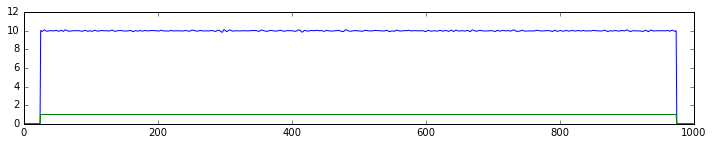

In [73]:
import sys,os
from numba import jit
sys.path.insert(0, os.path.join(sys.path[0], '..'))
import extnumba as xn

@jit(nopython=True)
def localCorr_numba(reference, match, winlen, nlag,lag,qual):
    hwin = winlen//2
    lags = 2*nlag+1
    ns = reference.shape[0]
    hxw = hwin-nlag
    cor = np.zeros(lags)
    refSSQ = np.zeros(ns)
    matSSQ = np.zeros(ns)
    xn.winSSQ(reference,2*hxw+1,refSSQ)
    xn.winSSQ(match,2*hxw+1,matSSQ)
    for ir in range(hwin,ns-hwin):
        rbeg = ir - hxw
        rend = ir + hxw + 1
        mbeg = rbeg - nlag
        mend = rend + nlag
        for il in range(lags):
            lbeg = rbeg + il - nlag
            lend = lbeg + 2 * hxw + 1
            sum = 0.0
            for iref,imat in zip(range(rbeg,rend),range(lbeg,lend)):
                sum += reference[iref]*match[imat]
            den = refSSQ[ir]*matSSQ[lbeg+hxw]
            if den== 0.0:
                cor[il] = 0.0
            else:
                cor[il] = sum/den
        pos = np.argmax(cor)
        if pos>0 and pos<lags-1:
            cp = (cor[pos-1]-cor[pos+1])/(2.*cor[pos-1]-4.*cor[pos]+2.*cor[pos+1])
            lag[ir] = pos-nlag+cp
            qual[ir] = cor[pos]
        else:
            lag[ir]=0.0
            qual[ir]=0.0

localCorr_numba(res,shifted,51,15,lag,qual)
fig = plt.figure(figsize=(12,2))
plt.plot(lag)
plt.plot(qual)

In [74]:
%timeit -o localCorr_numba(res,shifted,51,15,lag,qual)

100 loops, best of 3: 2.16 ms per loop


<TimeitResult : 100 loops, best of 3: 2.16 ms per loop>

The Numba version is ~6 times faster.

## Local Normalised Cross-correlation External Attribute
Here is the result using the same seismic test case shown above but using a local normalised cross-correlation external attribute script. Results are clearly superior to the Match Delta attribute albeit with a longer calculation time. 
![](images/local_ncc.jpeg)
Along with the delay estimate the attribute can also output the correlation coefficient with 1 indicating perfect correlation and 0 no correlation which provides a quality control measure.
![](images/local_ncc_qual.jpeg)